In [1]:
import pandas as pd
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sn

from tensorflow.keras.layers import Input,Dense,Bidirectional,Conv2D,MaxPooling2D,Flatten,concatenate,GlobalAveragePooling2D,BatchNormalization,Lambda,Add,Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow.keras.backend as K

from transformers import AutoTokenizer, TFAutoModel, TFBertModel, logging

from utilities import *

logging.set_verbosity_error()

In [2]:
train=pd.read_csv('train_final.csv',index_col=[0]).fillna(' ')
test=pd.read_csv('test_final.csv', index_col=[0]).fillna(' ')

In [3]:
def class_block(inputs):
    X = tf.keras.layers.BatchNormalization()(inputs)
    X = tf.keras.layers.Dense(512, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    X = tf.keras.layers.Dense(128, activation='relu')(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    
    y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(X)  # 3 labels due to three sentiment classes

    return y

In [4]:
def GMU(inp1, inp2, leng=768):
    hv=tf.keras.layers.Dense(leng,activation='tanh')(inp1)
    ht=tf.keras.layers.Dense(leng,activation='tanh')(inp2)
    concat=tf.keras.layers.concatenate([inp1,inp2])
    z=Dense(leng,activation='sigmoid')(concat)
    mult1=tf.keras.layers.Multiply()([z,hv])
    mult2=tf.keras.layers.Multiply()([tf.keras.layers.Lambda(lambda x: 1. - x)(z),ht])
    h=Add()([mult1,mult2])
    return h

In [5]:
def linear_sum(inp1, inp2, leng=768):
    hv=tf.keras.layers.Dense(leng,activation='relu')(inp1)
    ht=tf.keras.layers.Dense(leng,activation='relu')(inp2)
    h=Add()([hv,ht])
    return h

In [6]:
#optimizer = tf.keras.optimizers.Adam(0.0001)
optimizer= tf.keras.optimizers.RMSprop(0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
iterations=10

seq_len=50
seq_len2=10

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# TEXT

### CHOICE OF THE BEST PRE-TRAINED BERT EMBEDDER

Tried

- "dbmdz/bert-base-italian-cased"
- "neuraly/bert-base-italian-cased-sentiment"  
- "indigo-ai/BERTino" 
- __"unideeplearning/polibert_sa"__
- "distilbert-base-multilingual-cased" 

Only showing the best one. 

#### Model selection

In [7]:
model=  "unideeplearning/polibert_sa"
tokenizer = AutoTokenizer.from_pretrained(model)
bert = TFBertModel.from_pretrained(model)

#### Data import

In [8]:
dataset = df_to_tf_data(df=train, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=False, image=False, shuffle=True)

valset= df_to_tf_data(df=test, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=False, image=False, shuffle=False)

#### Model creation and fitting

In [9]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]  # we only keep tensor 0 (last_hidden_state)
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)  # reduce tensor dimensionality
y=class_block(X)


model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# freeze the DistilBERT layer
model.layers[2].trainable = False

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 110695680   input_ids[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 768)          0           tf_bert_model[0][0]              
______________________________________________________________________________________________

In [11]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [11]:
history = model.fit(dataset,validation_data=valset, epochs=iterations, callbacks=[model_checkpoint_callback])

Epoch 1/10
1187/1187 [==============================] - 174s 147ms/step - loss: 1.1012 - accuracy: 0.4966 - val_loss: 0.8730 - val_accuracy: 0.6230
Epoch 2/10
1187/1187 [==============================] - 173s 146ms/step - loss: 0.9971 - accuracy: 0.5588 - val_loss: 0.9131 - val_accuracy: 0.6253
Epoch 3/10
1187/1187 [==============================] - 172s 145ms/step - loss: 0.9567 - accuracy: 0.5737 - val_loss: 0.8880 - val_accuracy: 0.6159
Epoch 4/10
1187/1187 [==============================] - 172s 145ms/step - loss: 0.9489 - accuracy: 0.5799 - val_loss: 0.9589 - val_accuracy: 0.5956
Epoch 5/10
1187/1187 [==============================] - 172s 145ms/step - loss: 0.9167 - accuracy: 0.6018 - val_loss: 0.9453 - val_accuracy: 0.6011
Epoch 6/10
1187/1187 [==============================] - 173s 146ms/step - loss: 0.9145 - accuracy: 0.6005 - val_loss: 0.9430 - val_accuracy: 0.6245
Epoch 7/10
1187/1187 [==============================] - 173s 146ms/step - loss: 0.8874 - accuracy: 0.6043 - val_

#### Loss and Accuracy history

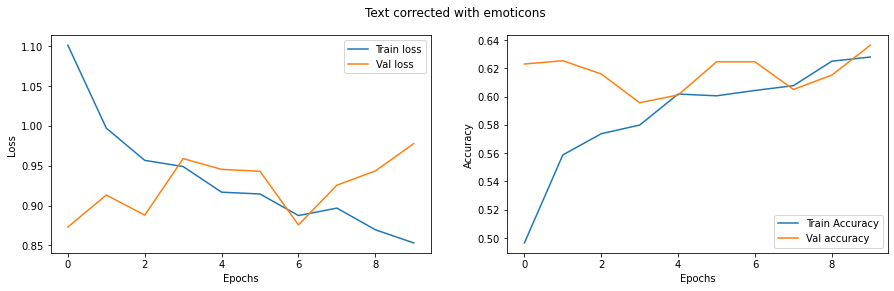

In [12]:
plot_history(history.history, title='Text corrected with emoticons', save=True)

#### Best model loading and confusion matrix

In [13]:
model.load_weights(checkpoint_filepath)

In [14]:
y_pred=model.predict(valset); y_true = np.concatenate([y for x, y in valset], axis=0)

In [15]:
y_pred_n=np.argmax(y_pred, axis=1); y_true_n= np.argmax(y_true, axis=1)
test2=test.copy(); test2['pred']=y_pred_n; test2['pred']=y_pred_n


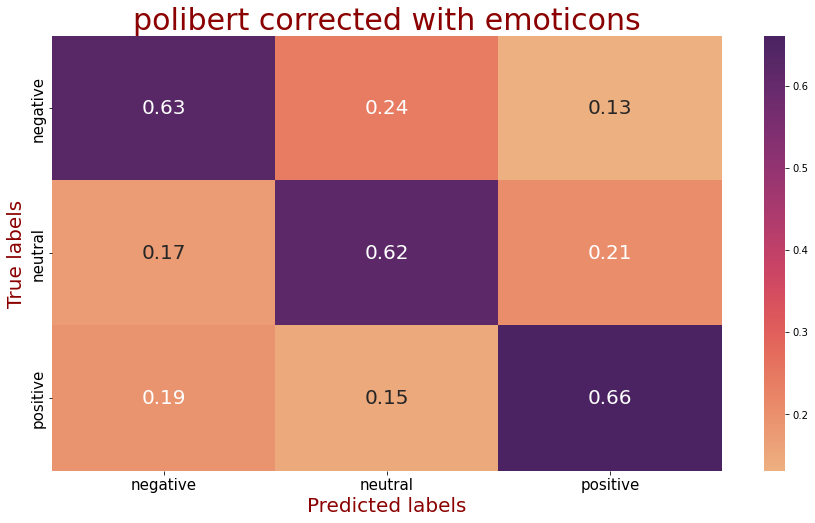

In [16]:
confusion_matrix_plotter(true=y_true_n, pred=y_pred_n, normalize='true',title='polibert corrected with emoticons')

In [ ]:
test2.head(30)

In [17]:
model.predict([tokenize('🤢', tokenizer,50, emotic=True)])

array([[9.9882811e-01, 8.0772972e-04, 3.6409678e-04]], dtype=float32)

## TEXT + TEXT

#### Early conc

In [7]:
dataset = df_to_tf_data(df=train, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=False, shuffle=True)

valset= df_to_tf_data(df=test, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=False, shuffle=False)

NameError: name 'tokenizer' is not defined

In [8]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
input_ids2 = tf.keras.layers.Input(shape=(seq_len2,), name='input_ids2', dtype='int32')
mask2 = tf.keras.layers.Input(shape=(seq_len2,), name='attention_mask2', dtype='int32')

input_ids_c=tf.keras.layers.concatenate([input_ids, input_ids2])
mask_c=tf.keras.layers.concatenate([mask, mask2])

embeddings = bert(input_ids_c, attention_mask=mask_c)[0]  # we only keep tensor 0 (last_hidden_state)
X = tf.keras.layers.GlobalMaxPool1D()(embeddings)  # reduce tensor dimensionality
y=class_block(X)


model = tf.keras.Model(inputs=[input_ids, mask, input_ids2, mask2], outputs=y)

# freeze the DistilBERT layer
model.layers[6].trainable = False

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids2 (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask2 (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

In [10]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [11]:
history = model.fit(dataset,validation_data=valset, epochs=iterations, callbacks=[model_checkpoint_callback])

Epoch 1/10
1187/1187 [==============================] - 187s 158ms/step - loss: 1.0718 - accuracy: 0.5331 - val_loss: 0.8685 - val_accuracy: 0.6284
Epoch 2/10
1187/1187 [==============================] - 185s 156ms/step - loss: 0.9635 - accuracy: 0.5708 - val_loss: 0.8603 - val_accuracy: 0.6542
Epoch 3/10
1187/1187 [==============================] - 184s 155ms/step - loss: 0.9246 - accuracy: 0.5933 - val_loss: 0.8441 - val_accuracy: 0.6269
Epoch 4/10
1187/1187 [==============================] - 184s 155ms/step - loss: 0.9160 - accuracy: 0.5921 - val_loss: 0.8910 - val_accuracy: 0.6362
Epoch 5/10
1187/1187 [==============================] - 186s 156ms/step - loss: 0.8887 - accuracy: 0.6058 - val_loss: 0.9041 - val_accuracy: 0.6378
Epoch 6/10
1187/1187 [==============================] - 187s 157ms/step - loss: 0.8659 - accuracy: 0.6165 - val_loss: 0.8995 - val_accuracy: 0.6409
Epoch 7/10
1187/1187 [==============================] - 188s 158ms/step - loss: 0.8796 - accuracy: 0.6209 - val_

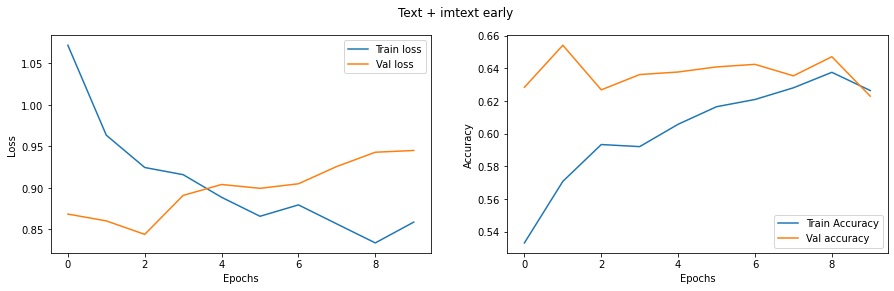

In [13]:
plot_history(history.history, title='Text + imtext early', save=False)

#### Late conc

In [9]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
input_ids2 = tf.keras.layers.Input(shape=(seq_len2,), name='input_ids2', dtype='int32')
mask2 = tf.keras.layers.Input(shape=(seq_len2,), name='attention_mask2', dtype='int32')



embeddings = bert(input_ids, attention_mask=mask)[0]  # we only keep tensor 0 (last_hidden_state)
embeddings2 = bert(input_ids2, attention_mask=mask2)[0]

X1 = tf.keras.layers.GlobalMaxPool1D()(embeddings)  # reduce tensor dimensionality
X2 = tf.keras.layers.GlobalMaxPool1D()(embeddings2)  # reduce tensor dimensionality
X = tf.keras.layers.concatenate([X1, X2])


y=class_block(X)


model = tf.keras.Model(inputs=[input_ids, mask, input_ids2, mask2], outputs=y)

# freeze the DistilBERT layer
model.layers[4].trainable = False

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids2 (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
attention_mask2 (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

In [11]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [12]:
history = model.fit(dataset,validation_data=valset, epochs=iterations, callbacks=[model_checkpoint_callback])

Epoch 1/10
1187/1187 [==============================] - 210s 177ms/step - loss: 1.1161 - accuracy: 0.5002 - val_loss: 0.9038 - val_accuracy: 0.6175
Epoch 2/10
1187/1187 [==============================] - 206s 174ms/step - loss: 0.9995 - accuracy: 0.5605 - val_loss: 0.9385 - val_accuracy: 0.6222
Epoch 3/10
1187/1187 [==============================] - 204s 172ms/step - loss: 0.9385 - accuracy: 0.5811 - val_loss: 0.8939 - val_accuracy: 0.6276
Epoch 4/10
1187/1187 [==============================] - 205s 173ms/step - loss: 0.9289 - accuracy: 0.5908 - val_loss: 0.9259 - val_accuracy: 0.6448
Epoch 5/10
1187/1187 [==============================] - 203s 171ms/step - loss: 0.8995 - accuracy: 0.6032 - val_loss: 0.9978 - val_accuracy: 0.6027
Epoch 6/10
1187/1187 [==============================] - 205s 173ms/step - loss: 0.8989 - accuracy: 0.6108 - val_loss: 0.9959 - val_accuracy: 0.6222
Epoch 7/10
1187/1187 [==============================] - 204s 172ms/step - loss: 0.8710 - accuracy: 0.6243 - val_

#### Late GMU

In [14]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
input_ids2 = tf.keras.layers.Input(shape=(seq_len2,), name='input_ids2', dtype='int32')
mask2 = tf.keras.layers.Input(shape=(seq_len2,), name='attention_mask2', dtype='int32')



embeddings = bert(input_ids, attention_mask=mask)[0]  # we only keep tensor 0 (last_hidden_state)
embeddings2 = bert(input_ids2, attention_mask=mask2)[0]

X1 = tf.keras.layers.GlobalMaxPool1D()(embeddings)  # reduce tensor dimensionality
X2 = tf.keras.layers.GlobalMaxPool1D()(embeddings2)  # reduce tensor dimensionality
X = GMU(X1,X2)


y=class_block(X)


model = tf.keras.Model(inputs=[input_ids, mask, input_ids2, mask2], outputs=y)

# freeze the DistilBERT layer
model.layers[4].trainable = False

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids2 (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
attention_mask2 (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

In [16]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [19]:
history = model.fit(dataset,validation_data=valset, epochs=iterations, callbacks=[model_checkpoint_callback])

Epoch 1/10
1187/1187 [==============================] - 216s 182ms/step - loss: 1.0637 - accuracy: 0.5291 - val_loss: 1.0158 - val_accuracy: 0.5847
Epoch 2/10
1187/1187 [==============================] - 210s 177ms/step - loss: 0.9871 - accuracy: 0.5603 - val_loss: 0.9782 - val_accuracy: 0.6089
Epoch 3/10
1187/1187 [==============================] - 210s 177ms/step - loss: 0.9537 - accuracy: 0.5858 - val_loss: 1.0327 - val_accuracy: 0.5777
Epoch 4/10
1187/1187 [==============================] - 210s 177ms/step - loss: 0.9337 - accuracy: 0.5925 - val_loss: 1.1000 - val_accuracy: 0.5925
Epoch 5/10
1187/1187 [==============================] - 212s 179ms/step - loss: 0.9037 - accuracy: 0.6007 - val_loss: 1.0658 - val_accuracy: 0.6105
Epoch 6/10
1187/1187 [==============================] - 209s 176ms/step - loss: 0.8990 - accuracy: 0.6199 - val_loss: 1.2301 - val_accuracy: 0.5660
Epoch 7/10
1187/1187 [==============================] - 209s 176ms/step - loss: 0.8809 - accuracy: 0.6172 - val_

## SOLO IMMAGINI

Tried

- Resent50V2
- Resenet100V2
- InceptionresnetV2

Only showing the best one (with and without data augumentation).

### No aug

In [7]:
dataset = df_to_tf_data(df=train, tokenizer=None, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=False, imtxt=False, image=True, shuffle=True)

valset= df_to_tf_data(df=test, tokenizer=None, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=False, imtxt=False, image=True, shuffle=False)

shape=(224,224,3)

In [7]:
CNN=tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=shape, pooling=False)

In [8]:
image_inputs=tf.keras.layers.Input(shape=shape,name="meme_images")

image_step=CNN(image_inputs)
X=GlobalAveragePooling2D()(image_step)
y=class_block(X)

model=Model(inputs=image_inputs,outputs=y)
model.layers[1].trainable = False
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
meme_images (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664 

In [9]:
history = model.fit(dataset,validation_data=valset, epochs=iterations, callbacks=[model_checkpoint_callback])

Epoch 1/10
1187/1187 [==============================] - 127s 107ms/step - loss: 1.1824 - accuracy: 0.4182 - val_loss: 1.1231 - val_accuracy: 0.4496
Epoch 2/10
1187/1187 [==============================] - 124s 105ms/step - loss: 1.0286 - accuracy: 0.5088 - val_loss: 1.1305 - val_accuracy: 0.4637
Epoch 3/10
1187/1187 [==============================] - 124s 104ms/step - loss: 0.9474 - accuracy: 0.5592 - val_loss: 1.1643 - val_accuracy: 0.4637
Epoch 4/10
1187/1187 [==============================] - 124s 104ms/step - loss: 0.9061 - accuracy: 0.5853 - val_loss: 1.2051 - val_accuracy: 0.4762
Epoch 5/10
1187/1187 [==============================] - 124s 104ms/step - loss: 0.8434 - accuracy: 0.6361 - val_loss: 1.2665 - val_accuracy: 0.4520
Epoch 6/10
1187/1187 [==============================] - 124s 104ms/step - loss: 0.7957 - accuracy: 0.6481 - val_loss: 1.3433 - val_accuracy: 0.4660
Epoch 7/10
1187/1187 [==============================] - 124s 104ms/step - loss: 0.7739 - accuracy: 0.6679 - val_

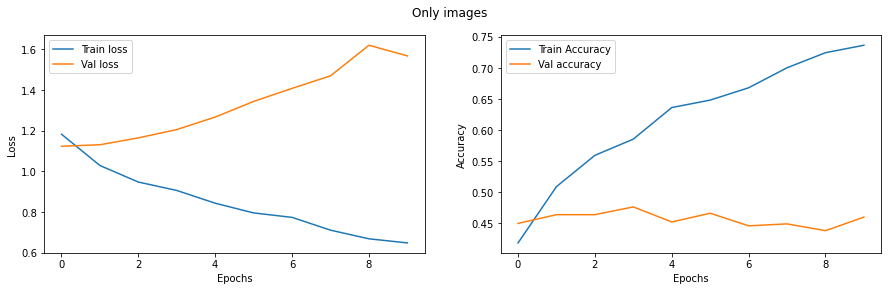

In [10]:
plot_history(history.history, title='Only images', save=False)

In [11]:
model.load_weights(checkpoint_filepath)

In [12]:
y_pred=model.predict(valset); y_true = np.concatenate([y for x, y in valset], axis=0)

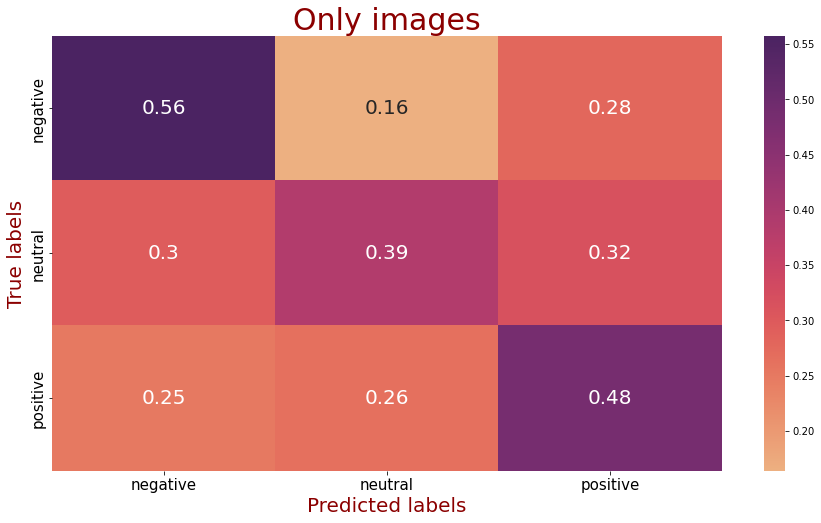

In [13]:
y_pred_n=np.argmax(y_pred, axis=1); y_true_n= np.argmax(y_true, axis=1)
test2=test.copy(); test2['pred']=y_pred_n; test2['pred']=y_pred_n
confusion_matrix_plotter(true=y_true_n, pred=y_pred_n, normalize='true',title='Only images')


In [14]:
test2.tail(40)

id                                               text  \
1241  1269041828717830149  Amici17/Amici19\nStessi brividi.\nStesse emozi...   
1242  1259458188124008448  NENO @StefanoFarinet1 che ascolta Ragazza occh...   
1243  1106297703036792833  Sento che non arriverò a fine puntata senza pi...   
1244  1109424396240908288  Che Dio ci aiuti sbarca ad Assisi!! Che bello!...   
1245  1283128847760752641  giulymol colpisce ancora belliii\n👇🏽👇🏽👇🏽\ninst...   
1246  1310950115897733120         @IGiudizi #amici19 https://t.co/J4hMHfLwkW   
1247  1320137559796834304  #costantinodellagherardesca versione Ted mosby...   
1248  1285297244091146241  #Javier e #Virginia\nChe belliii ❤️ \n#Amici19...   
1249  1320121984844505094  @Ballando_Rai @ElisaIsoardi @Raimondo_Todaro 😍...   
1250  1255758840290820097  #albertourso #Amici18 #AMICI19 #amicispeciali ...   
1251  1271177622698024962  Azzurra ci ha regalato delle grandi perle\n #c...   
1252  1257991742596546561  BEH CHE DIRE #Amici19 #giuliamolino #camicebia...   
1253  1209430728997556229  Mamma mia che ship potentissima sti due 😍 #che...   
1254  1271803530844745730  PRESALVIAMO TUTTI FACCIO TARDI PURE OGGI FORZA...   
1255  1168655914364284929  Più riguardo sta scena è più mi sciolgo😱😍😍 \nB...   
1256  1187826364889681920  PIANGO ❤️❤️❤️❤️ #CheDioCiAiuti https://t.co/gj...   
1257  1259519136004276226  "#albertourso #Amici18 #AMICI19 #amicispeciali...   
1258  1255096820595818497  + tenga e voglia fare il possibile, da sola po...   
1259  1104503429597184002  Io sti due non li supero ne ora ne mai #chedio...   
1260  1320111449109389314  Raimondo è tenero  #BallandoConLeStelle https:...   
1261  1268639445034598401  ECCO LA PERSONA CHE HA SALVATO TUTTE LE EDIZIO...   
1262  1255042190470000640  Ho appena scoperto che Random farà amici all s...   
1263  1266504586191425536  Il video per #gaiagozzi ricordi di questi bell...   
1264  1255492641728462848  arrivi dritto al cuore. #Amici19 #giuliamolino...   
1265  1283414184055779334  La perfezione non esis...🤤 no scusa, mi sbagli...   
1266  1255790387370786816  Amo follemente quest'esibizione di #Javier! No...   
1267  1267108505569447944  beh che dire, una dea.\n#giuliamolino #giulymo...   
1268  1269036973471207424  grazie irama,grazie per averne parlato.. ho la...   
1269  1283368532290527237  SENTITE QUA:\nMartina Beltrami, 19 anni \nConc...   
1270  1255586313606254592  Una meravigliosa poesia! \nTalento allo stato ...   
1271  1256210540017463304  Non si é parlato abbastanza della descrizione ...   
1272  1256233543597989893  Ci sarà un tempo per ricominciare\nper dimenti...   
1273  1257698522125737985  Solo io sono così sotto a da andare ogni dieci...   
1274  1320126753382203395  @Ale_Mussolini_ @Ballando_Rai @RaiUno @MaykelF...   
1275  1280986094570438657  TOP 15 INEDITI DEI RAGAZZI DI AMICI19\n\n#2\n🏆...   
1276  1281337387138916354      Uniche #chediociaiuti https://t.co/ZWeYMYRyjr   
1277  1106290904950665217  Ciao Azzurra 👋\nci mancherai ❤\n#CheDioCiAiuti...   
1278  1256168308824514560  ANDATE A STREAMMARE MEGLIO STAR DA SOLI E INAD...   
1279  1262441233353445376  Il mio sorriso mentre piangi resterà la mia vi...   
1280  1268110627530313728  “LUCI ACCESE” il primo singolo di @Martina__B_...   

     sentiment                                               path  \
1241  positive     ..\data\amici19\images\1269041828717830149.png   
1242  positive     ..\data\amici19\images\1259458188124008448.png   
1243  positive  ..\data\chediociaiuti\images\11062977030367928...   
1244  positive  ..\data\chediociaiuti\images\11094243962409082...   
1245  positive     ..\data\amici19\images\1283128847760752641.png   
1246  positive     ..\data\amici19\images\1310950115897733120.png   
1247  positive  ..\data\ballandoconlestelle\images\13201375597...   
1248  positive     ..\data\amici19\images\1285297244091146241.png   
1249  positive  ..\data\ballandoconlestelle\images\13201219848...   
1250  positive     ..\data\amici19\images\1255758840

In [15]:
test2['path'][0]

'..\\data\\chediociaiuti\\images\\1285259740096987136.png'

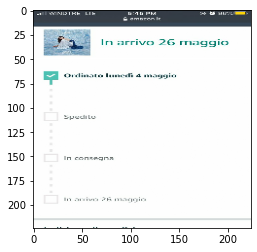

In [16]:
plt.imshow(preprocess_image(test2['path'][1273], 1)[0])

[[0.06919034 0.4055019  0.5253078 ]
 [0.8975192  0.07733165 0.02514915]
 [0.33908543 0.24909763 0.41181692]
 [0.62992203 0.08986652 0.28021145]]
tf.Tensor(
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]], shape=(4, 3), dtype=float64)
AxesImage(54,36;334.8x217.44)


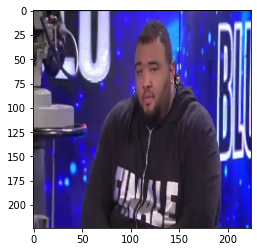

In [19]:
for x, y in valset.take(1):
    print(model.predict(x))
    print(y)
    print (plt.imshow(x[1]))


### Data aug

In [7]:
dataset = df_to_tf_data(df=train, tokenizer=None, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=False, imtxt=False, image=True, shuffle=True, augmentation=True)

valset= df_to_tf_data(df=test, tokenizer=None, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=False, imtxt=False, image=True, shuffle=False)

shape=(224,224,3)

In [8]:
CNN=tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=shape, pooling=False)

In [9]:
image_inputs=tf.keras.layers.Input(shape=shape,name="meme_images")

image_step=CNN(image_inputs)
X=GlobalAveragePooling2D()(image_step)
y=class_block(X)

model=Model(inputs=image_inputs,outputs=y)
model.layers[1].trainable = False
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
meme_images (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664 

In [10]:
history = model.fit(dataset,validation_data=valset, epochs=iterations, callbacks=[model_checkpoint_callback])

Epoch 1/10
1187/1187 [==============================] - 129s 109ms/step - loss: 1.1909 - accuracy: 0.4081 - val_loss: 1.2195 - val_accuracy: 0.4114
Epoch 2/10
1187/1187 [==============================] - 127s 107ms/step - loss: 1.0766 - accuracy: 0.4798 - val_loss: 1.2117 - val_accuracy: 0.4333
Epoch 3/10
1187/1187 [==============================] - 127s 107ms/step - loss: 1.0238 - accuracy: 0.5177 - val_loss: 1.2242 - val_accuracy: 0.4411
Epoch 4/10
1187/1187 [==============================] - 127s 107ms/step - loss: 0.9999 - accuracy: 0.5329 - val_loss: 1.2293 - val_accuracy: 0.4551
Epoch 5/10
1187/1187 [==============================] - 126s 106ms/step - loss: 0.9574 - accuracy: 0.5632 - val_loss: 1.3000 - val_accuracy: 0.4387
Epoch 6/10
1187/1187 [==============================] - 126s 106ms/step - loss: 0.9470 - accuracy: 0.5643 - val_loss: 1.3270 - val_accuracy: 0.4317
Epoch 7/10
1187/1187 [==============================] - 126s 106ms/step - loss: 0.9009 - accuracy: 0.5792 - val_

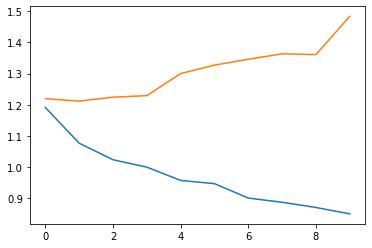

In [11]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

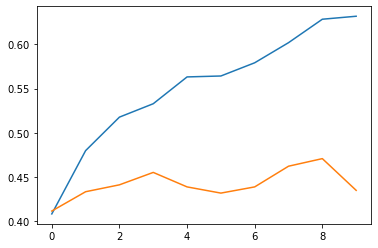

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# Testo e Immagini 

### Concatenation

In [7]:
dataset = df_to_tf_data(df=train, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=True, shuffle=True)

valset= df_to_tf_data(df=test, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=True, shuffle=False)

In [8]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
input_ids2 = tf.keras.layers.Input(shape=(seq_len2,), name='input_ids2', dtype='int32')
mask2 = tf.keras.layers.Input(shape=(seq_len2,), name='attention_mask2', dtype='int32')

input_ids_c=tf.keras.layers.concatenate([input_ids, input_ids2])
mask_c=tf.keras.layers.concatenate([mask, mask2])

image_inputs=tf.keras.layers.Input(shape=(224,224,3),name="images")

text_embeddings = bert(input_ids_c, attention_mask=mask_c)[0]  # we only keep tensor 0 (last_hidden_state)
text_1d = tf.keras.layers.GlobalMaxPool1D()(text_embeddings)  # reduce tensor dimensionality

image_embeddings=tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=False, classes=3)(image_inputs)
image_1d=GlobalAveragePooling2D()(image_embeddings)

X=tf.keras.layers.concatenate([text_1d, image_1d])

y=class_block(X)

model = tf.keras.Model(inputs=[input_ids, mask,input_ids2, mask2, image_inputs], outputs=y)

# freeze the DistilBERT layer
model.layers[7].trainable = False
model.layers[8].trainable = False

In [9]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids2 (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask2 (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

In [10]:
history = model.fit(dataset,validation_data=valset, epochs=iterations, callbacks=[model_checkpoint_callback])

Epoch 1/10
1187/1187 [==============================] - 305s 257ms/step - loss: 1.0704 - accuracy: 0.5324 - val_loss: 0.9087 - val_accuracy: 0.6339
Epoch 2/10
1187/1187 [==============================] - 300s 253ms/step - loss: 0.8975 - accuracy: 0.6062 - val_loss: 0.9057 - val_accuracy: 0.6495
Epoch 3/10
1187/1187 [==============================] - 299s 252ms/step - loss: 0.8207 - accuracy: 0.6511 - val_loss: 0.9624 - val_accuracy: 0.6370
Epoch 4/10
1187/1187 [==============================] - 299s 252ms/step - loss: 0.7522 - accuracy: 0.6884 - val_loss: 1.0130 - val_accuracy: 0.6222
Epoch 5/10
1187/1187 [==============================] - 301s 254ms/step - loss: 0.7110 - accuracy: 0.7090 - val_loss: 1.0116 - val_accuracy: 0.6542
Epoch 6/10
1187/1187 [==============================] - 301s 254ms/step - loss: 0.6621 - accuracy: 0.7295 - val_loss: 1.0793 - val_accuracy: 0.6589
Epoch 7/10
1187/1187 [==============================] - 300s 252ms/step - loss: 0.6156 - accuracy: 0.7590 - val_

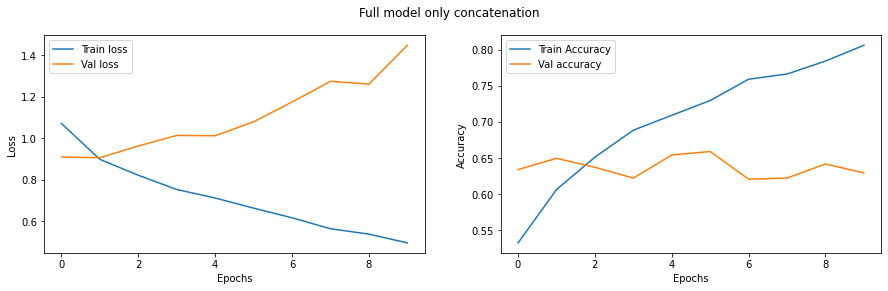

In [13]:
plot_history(history.history, title='Full model only concatenation', save=True)

In [14]:
model.load_weights(checkpoint_filepath)

In [15]:
y_pred=model.predict(valset); y_true = np.concatenate([y for x, y in valset], axis=0)
y_pred_n=np.argmax(y_pred, axis=1); y_true_n= np.argmax(y_true, axis=1)
test2=test.copy(); test2['pred']=y_pred_n; test2['pred']=y_pred_n



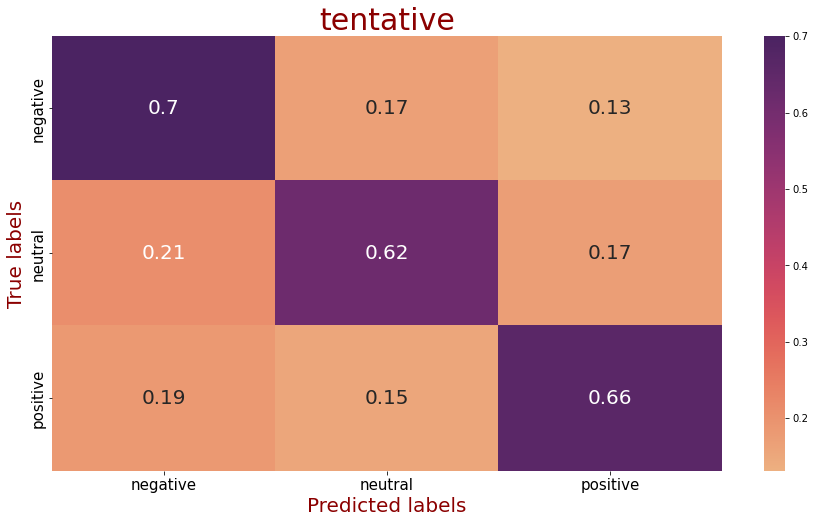

In [16]:
confusion_matrix_plotter(true=y_true_n, pred=y_pred_n, normalize='true',title='tentative', save=True)

### GMU

In [7]:
dataset = df_to_tf_data(df=train, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=True, shuffle=True)

valset= df_to_tf_data(df=test, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=True, shuffle=False)

In [9]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
input_ids2 = tf.keras.layers.Input(shape=(seq_len2,), name='input_ids2', dtype='int32')
mask2 = tf.keras.layers.Input(shape=(seq_len2,), name='attention_mask2', dtype='int32')

input_ids_c=tf.keras.layers.concatenate([input_ids, input_ids2])
mask_c=tf.keras.layers.concatenate([mask, mask2])

image_inputs=tf.keras.layers.Input(shape=(224,224,3),name="images")

text_embeddings = bert(input_ids_c, attention_mask=mask_c)[0]  # we only keep tensor 0 (last_hidden_state)
text_1d = tf.keras.layers.GlobalMaxPool1D()(text_embeddings)  # reduce tensor dimensionality

image_embeddings=tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', 
                                                  input_tensor=None, input_shape=(224,224,3),
                                                  pooling=False, classes=3)(image_inputs)
image_1d=GlobalAveragePooling2D()(image_embeddings)

X=GMU(text_1d, image_1d)

y=class_block(X)

model = tf.keras.Model(inputs=[input_ids, mask,input_ids2, mask2, image_inputs], outputs=y)

# freeze the DistilBERT layer
model.layers[7].trainable = False
model.layers[8].trainable = False

In [10]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids2 (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask2 (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

In [11]:
history = model.fit(dataset,validation_data=valset, epochs=iterations, callbacks=[model_checkpoint_callback])

Epoch 1/10
1187/1187 [==============================] - 316s 266ms/step - loss: 1.0625 - accuracy: 0.5306 - val_loss: 0.9681 - val_accuracy: 0.6097
Epoch 2/10
1187/1187 [==============================] - 312s 263ms/step - loss: 0.8927 - accuracy: 0.6051 - val_loss: 0.9150 - val_accuracy: 0.6308
Epoch 3/10
1187/1187 [==============================] - 314s 264ms/step - loss: 0.8304 - accuracy: 0.6445 - val_loss: 0.9526 - val_accuracy: 0.6393
Epoch 4/10
1187/1187 [==============================] - 313s 264ms/step - loss: 0.7690 - accuracy: 0.6696 - val_loss: 1.0119 - val_accuracy: 0.6190
Epoch 5/10
1187/1187 [==============================] - 311s 262ms/step - loss: 0.7328 - accuracy: 0.6913 - val_loss: 1.1544 - val_accuracy: 0.5925
Epoch 6/10
1187/1187 [==============================] - 318s 268ms/step - loss: 0.6765 - accuracy: 0.7219 - val_loss: 1.0628 - val_accuracy: 0.6518
Epoch 7/10
1187/1187 [==============================] - 316s 266ms/step - loss: 0.6410 - accuracy: 0.7318 - val_

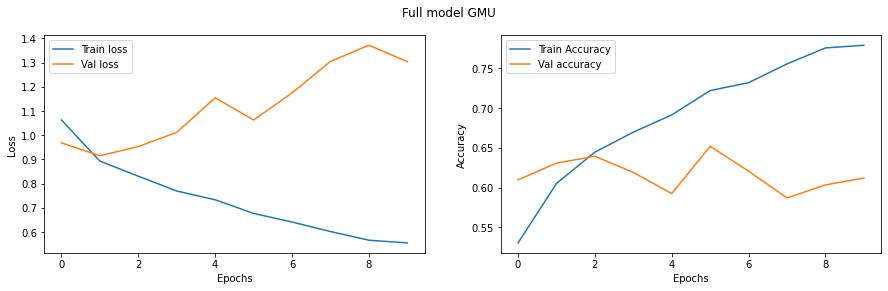

In [13]:
plot_history(history.history, title='Full model GMU', save=True)

In [14]:
model.load_weights(checkpoint_filepath)

In [15]:
y_pred=model.predict(valset); y_true = np.concatenate([y for x, y in valset], axis=0)
y_pred_n=np.argmax(y_pred, axis=1); y_true_n= np.argmax(y_true, axis=1)
test2=test.copy(); test2['pred']=y_pred_n; test2['pred']=y_pred_n



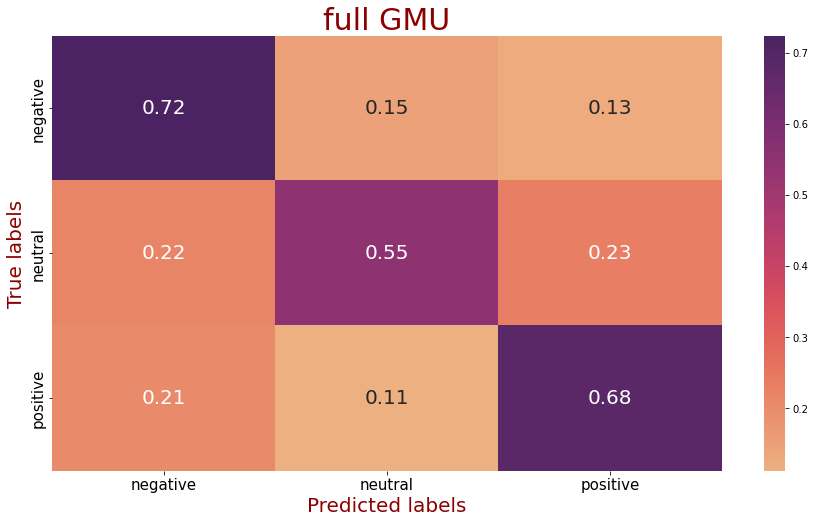

In [16]:
confusion_matrix_plotter(true=y_true_n, pred=y_pred_n, normalize='true',title='full GMU', save=True)

### Linear

In [8]:
dataset = df_to_tf_data(df=train, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=True, shuffle=True)

valset= df_to_tf_data(df=test, tokenizer=tokenizer, 
                        SEQ_LEN=seq_len, SEQ_LEN2=seq_len2, emotic=True,
                        txt=True, imtxt=True, image=True, shuffle=False)

In [9]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')
input_ids2 = tf.keras.layers.Input(shape=(seq_len2,), name='input_ids2', dtype='int32')
mask2 = tf.keras.layers.Input(shape=(seq_len2,), name='attention_mask2', dtype='int32')

input_ids_c=tf.keras.layers.concatenate([input_ids, input_ids2])
mask_c=tf.keras.layers.concatenate([mask, mask2])

image_inputs=tf.keras.layers.Input(shape=(224,224,3),name="images")

text_embeddings = bert(input_ids_c, attention_mask=mask_c)[0]  # we only keep tensor 0 (last_hidden_state)
text_1d = tf.keras.layers.GlobalMaxPool1D()(text_embeddings)  # reduce tensor dimensionality

image_embeddings=tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet', 
                                                  input_tensor=None, input_shape=(224,224,3),
                                                  pooling=False, classes=3)(image_inputs)
image_1d=GlobalAveragePooling2D()(image_embeddings)

X=linear_sum(text_1d, image_1d)

y=class_block(X)

model = tf.keras.Model(inputs=[input_ids, mask,input_ids2, mask2, image_inputs], outputs=y)

# freeze the DistilBERT layer
model.layers[7].trainable = False
model.layers[8].trainable = False

In [10]:
model.compile(optimizer=optimizer, loss=loss, metrics=[acc])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_ids2 (InputLayer)         [(None, 10)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
attention_mask2 (InputLayer)    [(None, 10)]         0                                            
______________________________________________________________________________________________

In [11]:
history = model.fit(dataset,validation_data=valset, epochs=iterations, callbacks=[model_checkpoint_callback])

Epoch 1/10
1187/1187 [==============================] - 310s 261ms/step - loss: 1.0403 - accuracy: 0.5312 - val_loss: 0.8688 - val_accuracy: 0.6308
Epoch 2/10
1187/1187 [==============================] - 303s 255ms/step - loss: 0.9076 - accuracy: 0.5957 - val_loss: 0.8812 - val_accuracy: 0.6292
Epoch 3/10
1187/1187 [==============================] - 308s 260ms/step - loss: 0.8277 - accuracy: 0.6422 - val_loss: 0.9197 - val_accuracy: 0.6425
Epoch 4/10
1187/1187 [==============================] - 305s 257ms/step - loss: 0.7852 - accuracy: 0.6677 - val_loss: 1.0475 - val_accuracy: 0.5941
Epoch 5/10
1187/1187 [==============================] - 303s 255ms/step - loss: 0.7454 - accuracy: 0.6869 - val_loss: 1.0276 - val_accuracy: 0.6378
Epoch 6/10
1187/1187 [==============================] - 306s 257ms/step - loss: 0.7163 - accuracy: 0.6960 - val_loss: 1.0080 - val_accuracy: 0.6440
Epoch 7/10
1187/1187 [==============================] - 305s 257ms/step - loss: 0.6608 - accuracy: 0.7358 - val_

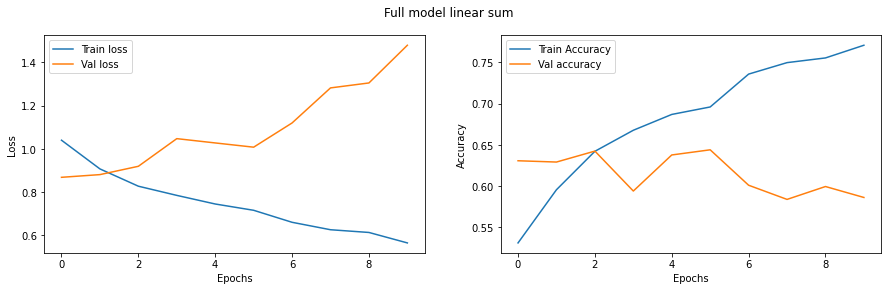

In [12]:
plot_history(history.history, title='Full model linear sum', save=True)

In [13]:
model.load_weights(checkpoint_filepath)

In [14]:
y_pred=model.predict(valset); y_true = np.concatenate([y for x, y in valset], axis=0)
y_pred_n=np.argmax(y_pred, axis=1); y_true_n= np.argmax(y_true, axis=1)
test2=test.copy(); test2['pred']=y_pred_n; test2['pred']=y_pred_n



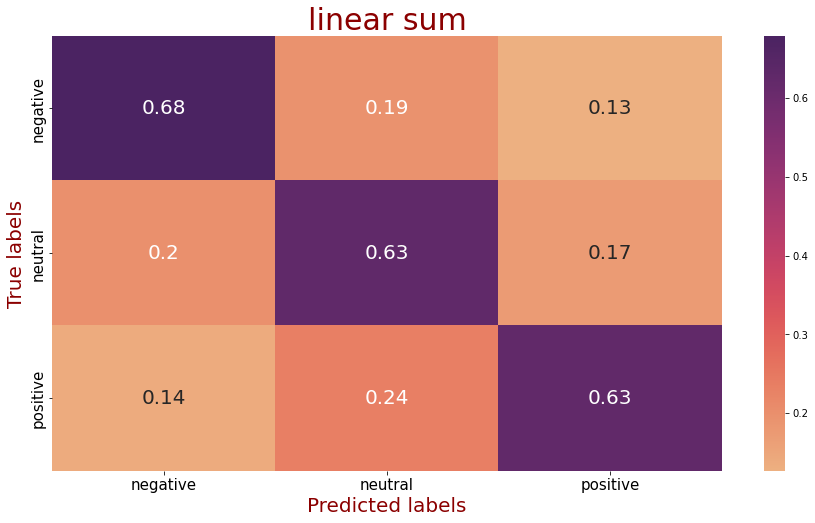

In [15]:
confusion_matrix_plotter(true=y_true_n, pred=y_pred_n, normalize='true',title='linear sum', save=True)

In [33]:
im=(preprocess_image(r'..\data\amici19\images\1269041828717830149.png', 1)[0])

In [182]:
def aug(image, IMG_SIZE=224):
    image = tf.image.random_brightness(image, 0.15)
    image = tf.image.random_contrast(image, upper=1.5, lower=0.5)
    image = tf.image.random_saturation(image,upper=1.5, lower=0.5)
    image = tf.image.random_hue(image, 0.15)
    if tf.random.uniform([])>0.5:
        image= tf.image.flip_left_right(image)
    if tf.random.uniform([])>0:
        image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6) 
   # Random crop back to the original size
        image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.clip_by_value(image, 0, 1)
    return image

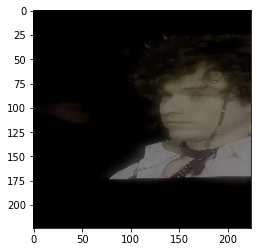

In [203]:
plt.imshow(aug(im))